Importing Libraries

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np

Determines Cuda or CPU

In [8]:
#Determines the device to use for the code
torch.set_default_device('cpu')
device = torch.device('cpu')
if torch.cuda.is_available():
    torch.set_default_device('cuda')
    device = torch.device('cuda')
print('Using device:', device)
torch.cuda.empty_cache()

Using device: cuda


Neural Network Creation

In [9]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten() #Creates a callable function to flatten the image data

        #Creates callable functions
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size = 3)
        self.fc1 = nn.Linear(27*27, 243)
        self.fc2 = nn.Linear(243, 81)
        self.fc3 = nn.Linear(81, 27)
        self.fc4 = nn.Linear(27, 4)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


#Define training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    losstr = 0
    for batch, (X, y) in enumerate(dataloader):
        torch.cuda.empty_cache()
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        losstr += loss / num_batches
    
    print(f'Avg loss: {losstr:>7f}')



#Define test loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            torch.cuda.empty_cache()
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Dataset and Category Creation

In [10]:
#Run this if using Google Colab (comment out if on files)
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir(os.path.join(os.getcwd(), 'drive/My Drive/BME450')) #change file path as needed

#Run only this if using files and change file path as needed
directory = os.path.join(os.getcwd(), 'MRI') #directory where the dataset is stored

#direc = r'paste filepath here' #use if cwd doesn't work
#directory = os.path.join(direc, 'MRI') #use if cwd doesn't work
print(directory)

c:\Users\User\OneDrive\Documents\BME45000\MRI


In [11]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary'] #creates a list to holder the categories

trainingdir = os.path.join(directory, 'Training') #directory where the training data is stored
testdir = os.path.join(directory, 'Testing') #directory where the testing data is stored

training_data = datasets.ImageFolder(
    trainingdir,
    transforms.Compose([
        transforms.ToTensor(), #converts the images into tensor format
        transforms.Grayscale(), #converts the images into grayscale (so they have 1 channel)
        transforms.Normalize(mean = 0, std = 1), #normalizes the image data with a set mean and std
        transforms.Resize((256, 256)), #resizes all the images to the same size
]))

test_data = datasets.ImageFolder(
    testdir,
    transforms.Compose([
        transforms.ToTensor(), #converts the images into tensor format
        transforms.Grayscale(), #converts the images into grayscale (so they have 1 channel)
        transforms.Normalize(mean = 0, std = 1), #normalizes the image data with a set mean and std
        transforms.Resize((256, 256)), #resizes all the images to the same size
]))

Network Training

In [12]:
model = NN()

batch_size = 10
learning_rate = 0.1

train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True, generator = torch.Generator(device))
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True, generator = torch.Generator(device))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1,5,8], gamma = 0.1)

epochs = 15
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    print('Learning Rate:', torch.optim.lr_scheduler.MultiStepLR.get_last_lr(scheduler))
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
Learning Rate: [0.1]
loss: 1.445880  [   10/ 5712]
loss: 1.395892  [ 1010/ 5712]
loss: 1.405749  [ 2010/ 5712]
loss: 1.275735  [ 3010/ 5712]
loss: 1.540334  [ 4010/ 5712]
loss: 1.097910  [ 5010/ 5712]
Avg loss: 1.175401
Test Error: 
 Accuracy: 39.0%, Avg loss: 1.383925 

Epoch 2
-------------------------------
Learning Rate: [0.010000000000000002]
loss: 1.797219  [   10/ 5712]
loss: 0.431586  [ 1010/ 5712]
loss: 0.494002  [ 2010/ 5712]
loss: 0.583825  [ 3010/ 5712]
loss: 1.011805  [ 4010/ 5712]
loss: 0.409294  [ 5010/ 5712]
Avg loss: 0.569421
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.621034 

Epoch 3
-------------------------------
Learning Rate: [0.010000000000000002]
loss: 0.454738  [   10/ 5712]
loss: 0.743283  [ 1010/ 5712]
loss: 0.095255  [ 2010/ 5712]
loss: 0.393602  [ 3010/ 5712]
loss: 0.270111  [ 4010/ 5712]
loss: 0.163783  [ 5010/ 5712]
Avg loss: 0.445564
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.548288 

Epoch 4
----------------------

Network Testing

Sample Number: 835
Pseudo Probabilities: tensor([[-2.3226,  6.4889,  9.1463, -8.7654]], device='cuda:0')
Actual Class: notumor
Predicted Class: notumor
Correct! :)


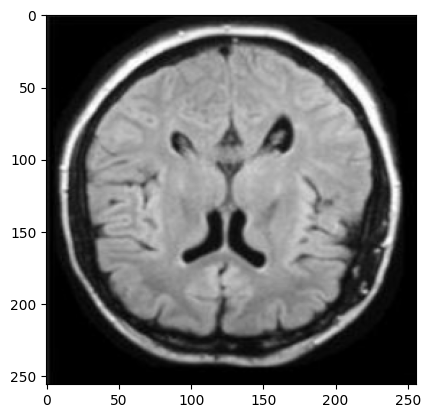

In [13]:
#finds random sample in range of dataset
size = len(test_data)
sample_num = np.random.randint(0, size)

#finds the actual class number and image data
sample = test_data[sample_num][0].to(device)
image = sample.permute(1, 2, 0)
plt.imshow(image.to('cpu'), cmap = 'gray')
act_class_num = test_data[sample_num][1]

#finds the predicted class number
with torch.no_grad():
    r = model(sample)
    pred_class_num = torch.argmax(r).item()

#prints the predicted and actuals classes, and whether they match
print('Sample Number:', sample_num)
print('Pseudo Probabilities:', r)
print('Actual Class:', categories[act_class_num])
print('Predicted Class:', categories[pred_class_num])
if(act_class_num == pred_class_num):
    print("Correct! :)")
else:
    print("Incorrect :(")